STEP 1: The Hemodynamic Response Function (HRF)

The HRF models the slow blood oxygenation response to neural activity.
When neurons fire, the BOLD signal peaks ~5-6 seconds later.



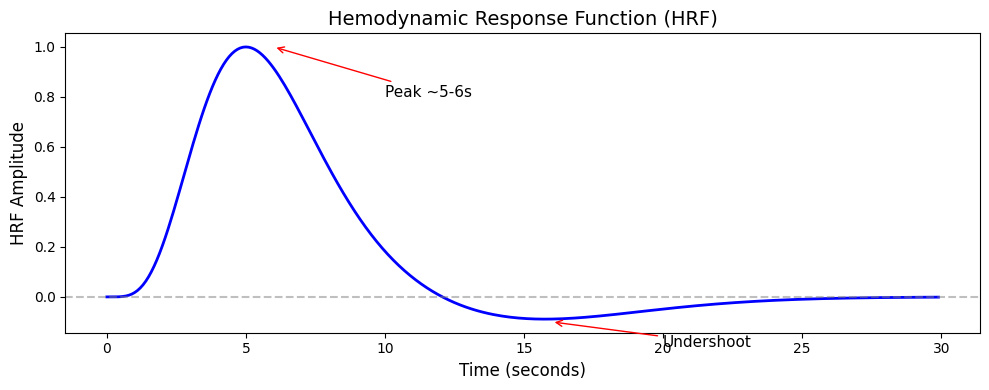

In [ ]:
"""
=============================================================================
PARAMETRIC MODULATION IN TASK fMRI: A Step-by-Step Tutorial
=============================================================================

What is Parametric Modulation?
------------------------------
In standard fMRI analysis, we model brain responses as "on" or "off" —
did this condition happen or not? But many cognitive processes vary in
INTENSITY, not just presence/absence.

Parametric modulation allows us to ask:
"Does brain activity SCALE with some continuous variable?"

Examples:
- Does reward-related activity increase with reward MAGNITUDE?
- Does prefrontal activity increase with task DIFFICULTY?
- Does memory activity scale with CONFIDENCE ratings?

The Math Behind It
------------------
Standard GLM:     Y = β₀ + β₁·X_condition + ε
                  (X is binary: 0 or 1)

Parametric GLM:   Y = β₀ + β₁·X_condition + β₂·X_parametric + ε
                  (X_parametric = X_condition × parameter_value)

The parametric regressor captures ADDITIONAL variance explained by the
trial-by-trial variation in your parameter.

Author: Tutorial for fMRI Education
"""

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gamma
from scipy import signal
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

# =============================================================================
# STEP 1: Define the Hemodynamic Response Function (HRF)
# =============================================================================
print("=" * 70)
print("STEP 1: The Hemodynamic Response Function (HRF)")
print("=" * 70)
print("""
The HRF models the slow blood oxygenation response to neural activity.
When neurons fire, the BOLD signal peaks ~5-6 seconds later.
""")

def hrf(t, peak1=6, peak2=16, ratio=6):
    """
    Double-gamma HRF function.

    Parameters:
    -----------
    t : array, time in seconds
    peak1 : peak of positive response (~6s)
    peak2 : peak of undershoot (~16s)
    ratio : ratio of positive to negative response
    """
    # Positive response (main peak)
    h1 = gamma.pdf(t, peak1)
    # Negative undershoot
    h2 = gamma.pdf(t, peak2)
    # Combine
    h = h1 - h2 / ratio
    return h / np.max(h)  # Normalize

# Create HRF
t_hrf = np.arange(0, 30, 0.1)  # 30 seconds, 0.1s resolution
hrf_curve = hrf(t_hrf)

# Visualize HRF
plt.figure(figsize=(10, 4))
plt.plot(t_hrf, hrf_curve, 'b-', linewidth=2)
plt.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
plt.xlabel('Time (seconds)', fontsize=12)
plt.ylabel('HRF Amplitude', fontsize=12)
plt.title('Hemodynamic Response Function (HRF)', fontsize=14)
plt.annotate('Peak ~5-6s', xy=(6, 1), xytext=(10, 0.8),
             arrowprops=dict(arrowstyle='->', color='red'), fontsize=11)
plt.annotate('Undershoot', xy=(16, -0.1), xytext=(20, -0.2),
             arrowprops=dict(arrowstyle='->', color='red'), fontsize=11)
plt.tight_layout()
plt.savefig('step1_hrf.png', dpi=150)
plt.show()


假设我们做了一个奖励任务。被试在扫描仪里完成任务，每个试次会获得不同金额的奖励：**1块、2块、3块、4块、或者5块钱**。一共20个试次，随机分配。


我们的问题是：哪些脑区的活动会随着奖励金额而增加？


STEP 2: Experimental Design with Parametric Values

Imagine a REWARD task where participants receive different reward amounts.
- 20 trials total
- Reward varies: $1, $2, $3, $4, or $5
- We want to find brain regions that scale with reward magnitude!

Number of trials: 20
Trial onsets (first 5): [16. 26. 52. 52. 60.] seconds
Reward values (first 5): $[3 2 4 4 3]

Reward distribution: {np.int64(1): np.int64(4), np.int64(2): np.int64(4), np.int64(3): np.int64(4), np.int64(4): np.int64(6), np.int64(5): np.int64(2)}


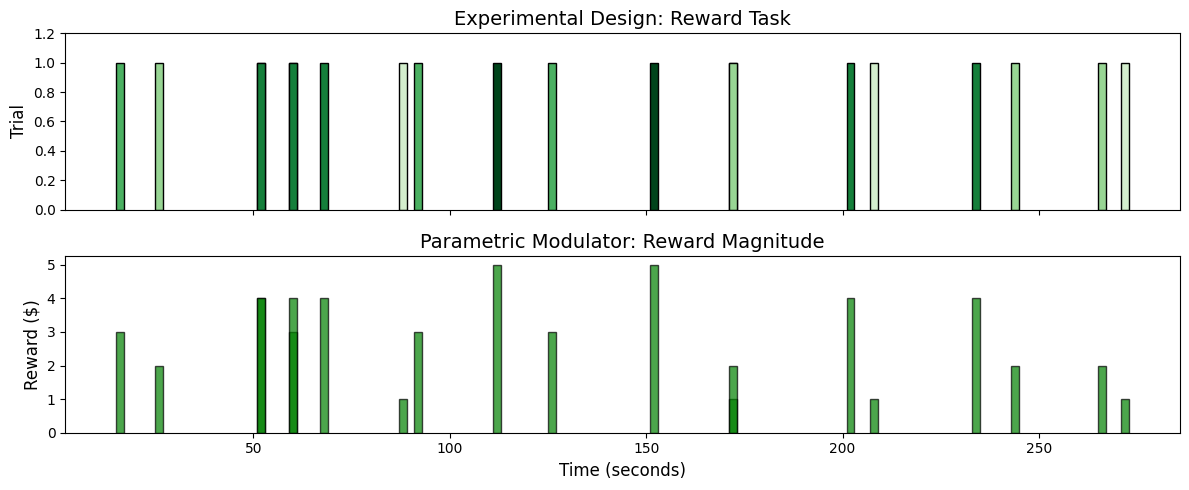

In [ ]:
# @title
# =============================================================================
# STEP 2: Create Experimental Design with Parametric Values
# =============================================================================
print("\n" + "=" * 70)
print("STEP 2: Experimental Design with Parametric Values")
print("=" * 70)
print("""
Imagine a REWARD task where participants receive different reward amounts.
- 20 trials total
- Reward varies: $1, $2, $3, $4, or $5
- We want to find brain regions that scale with reward magnitude!
""")

# Experimental parameters
TR = 2.0  # Repetition time (seconds)
n_volumes = 150  # Total fMRI volumes
total_time = n_volumes * TR  # 300 seconds = 5 minutes

# Trial timing (in seconds)
n_trials = 20
trial_onsets = np.sort(np.random.uniform(10, total_time - 20, n_trials))
trial_onsets = np.round(trial_onsets / TR) * TR  # Align to TRs

# Parametric values: Reward magnitude ($1-$5)
reward_magnitudes = np.random.choice([1, 2, 3, 4, 5], size=n_trials)

print(f"Number of trials: {n_trials}")
print(f"Trial onsets (first 5): {trial_onsets[:5]} seconds")
print(f"Reward values (first 5): ${reward_magnitudes[:5]}")
print(f"\nReward distribution: {dict(zip(*np.unique(reward_magnitudes, return_counts=True)))}")

# Visualize experimental design
fig, axes = plt.subplots(2, 1, figsize=(12, 5), sharex=True)

# Top: Trial onsets as impulses
colors = plt.cm.Greens(reward_magnitudes / 5)
for i, (onset, reward) in enumerate(zip(trial_onsets, reward_magnitudes)):
    axes[0].bar(onset, 1, width=2, color=colors[i], edgecolor='black')
axes[0].set_ylabel('Trial', fontsize=12)
axes[0].set_title('Experimental Design: Reward Task', fontsize=14)
axes[0].set_ylim(0, 1.2)

# Bottom: Parametric values
for onset, reward in zip(trial_onsets, reward_magnitudes):
    axes[1].bar(onset, reward, width=2, color='green', edgecolor='black', alpha=0.7)
axes[1].set_xlabel('Time (seconds)', fontsize=12)
axes[1].set_ylabel('Reward ($)', fontsize=12)
axes[1].set_title('Parametric Modulator: Reward Magnitude', fontsize=14)

plt.tight_layout()
plt.savefig('step2_experimental_design.png', dpi=150)
plt.show()


# **标准的GLM**：
\begin{equation}
Y = \beta_{0} + \beta_{1} \cdot X_{\text{condition}} + \epsilon
\end{equation}
这里的 \begin{equation}X_{condition}\end{equation} 是一个二分变量，0或者1。


<br>
<br>
<br>
<br>

# **参数调节的GLM**：
\begin{equation}
Y = \beta_{0} + \beta_{1} \cdot X_{\text{main}} + \beta_{2} \cdot X_{\text{parametric}} + \epsilon
\end{equation}




注意这里有两个回归因子：
> \begin{equation}
X_{main}
\end{equation}​ 是主效应，所有试次都是1

> \begin{equation}
X_{parametric}\end{equation}
 是参数调节，它的值会随着你感兴趣的参数而变化

# **中心化**

假设奖励金额:有1块、2块、3块、4块、5块。在做参数调节之前，你需要把这些值减去它们的平均值。

平均值是3，所以中心化之后就变成了：-2, -1, 0, 1, 2。

如果不中心化，主效应和参数调节会高度相关。

中心化之后，回归因子正交。这样主效应捕捉的是"平均反应"，参数调节捕捉的是"随参数变化的额外反应"。




STEP 3: Building the Design Matrix

KEY INSIGHT: We create TWO regressors:

1. MAIN EFFECT regressor: 
   - All trials have amplitude = 1
   - Asks: "Does this region respond to rewards AT ALL?"

2. PARAMETRIC MODULATOR regressor:
   - Amplitude = MEAN-CENTERED reward value
   - Asks: "Does response INCREASE with reward magnitude?"

Why mean-center? To make the regressors orthogonal (uncorrelated).
This separates the "main effect" from the "parametric effect".

Original rewards: [3 2 4 4 3]
Mean-centered:    [ 0.1 -0.9  1.1  1.1  0.1]
Mean of centered: 0.000000 (should be ~0)


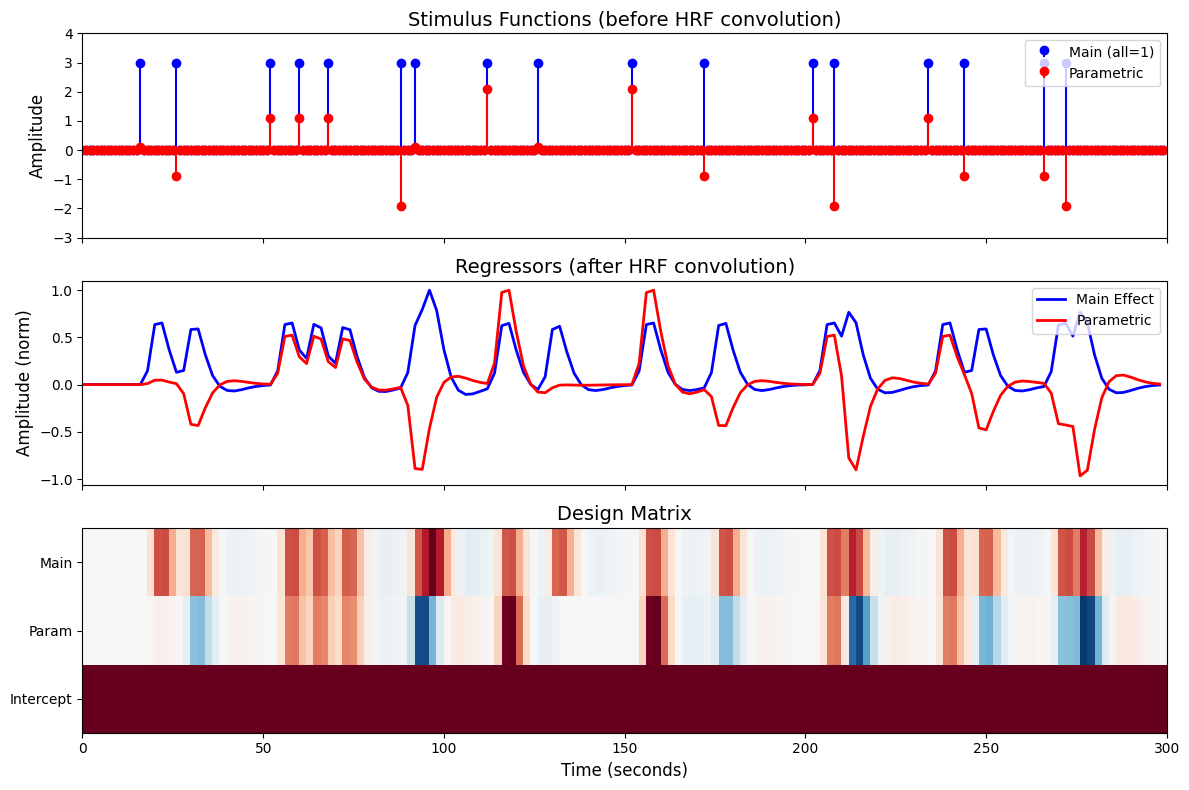


Correlation between Main and Parametric regressors: -0.0582
(Should be close to 0 due to mean-centering)


In [ ]:
# @title

# =============================================================================
# STEP 3: Build the Design Matrix (Standard vs Parametric)
# =============================================================================
print("\n" + "=" * 70)
print("STEP 3: Building the Design Matrix")
print("=" * 70)
print("""
KEY INSIGHT: We create TWO regressors:

1. MAIN EFFECT regressor:
   - All trials have amplitude = 1
   - Asks: "Does this region respond to rewards AT ALL?"

2. PARAMETRIC MODULATOR regressor:
   - Amplitude = MEAN-CENTERED reward value
   - Asks: "Does response INCREASE with reward magnitude?"

Why mean-center? To make the regressors orthogonal (uncorrelated).
This separates the "main effect" from the "parametric effect".
""")

# Time vector at fMRI resolution
time_fmri = np.arange(0, total_time, TR)

# High-resolution time for convolution
dt = 0.1  # 100ms resolution
time_highres = np.arange(0, total_time, dt)
hrf_highres = hrf(np.arange(0, 30, dt))

def create_regressor(onsets, amplitudes, time_highres, time_fmri, hrf_curve):
    """
    Create an fMRI regressor by convolving stimulus function with HRF.
    """
    # Create stimulus function (impulses at onset times)
    stim = np.zeros(len(time_highres))
    for onset, amp in zip(onsets, amplitudes):
        idx = int(onset / dt)
        if idx < len(stim):
            stim[idx] = amp

    # Convolve with HRF
    convolved = np.convolve(stim, hrf_curve, mode='full')[:len(stim)]

    # Downsample to TR
    regressor = np.interp(time_fmri, time_highres, convolved)

    return regressor, stim, convolved

# 1. MAIN EFFECT: All trials with amplitude = 1
main_amplitudes = np.ones(n_trials)
main_regressor, main_stim, main_conv = create_regressor(
    trial_onsets, main_amplitudes, time_highres, time_fmri, hrf_highres
)

# 2. PARAMETRIC MODULATOR: Mean-centered reward values
reward_centered = reward_magnitudes - np.mean(reward_magnitudes)
print(f"Original rewards: {reward_magnitudes[:5]}")
print(f"Mean-centered:    {reward_centered[:5]}")
print(f"Mean of centered: {np.mean(reward_centered):.6f} (should be ~0)")

param_regressor, param_stim, param_conv = create_regressor(
    trial_onsets, reward_centered, time_highres, time_fmri, hrf_highres
)

# Normalize regressors for visualization
main_regressor_norm = main_regressor / np.max(np.abs(main_regressor))
param_regressor_norm = param_regressor / np.max(np.abs(param_regressor))

# Visualize design matrix
fig, axes = plt.subplots(3, 1, figsize=(12, 8), sharex=True)

# Stimulus functions (before convolution)
axes[0].stem(time_highres[::10], main_stim[::10] * 3, 'b', markerfmt='bo',
             basefmt=' ', label='Main (all=1)')
axes[0].stem(time_highres[::10], param_stim[::10], 'r', markerfmt='ro',
             basefmt=' ', label='Parametric')
axes[0].set_ylabel('Amplitude', fontsize=12)
axes[0].set_title('Stimulus Functions (before HRF convolution)', fontsize=14)
axes[0].legend(loc='upper right')
axes[0].set_ylim(-3, 4)

# After convolution
axes[1].plot(time_fmri, main_regressor_norm, 'b-', linewidth=2, label='Main Effect')
axes[1].plot(time_fmri, param_regressor_norm, 'r-', linewidth=2, label='Parametric')
axes[1].set_ylabel('Amplitude (norm)', fontsize=12)
axes[1].set_title('Regressors (after HRF convolution)', fontsize=14)
axes[1].legend(loc='upper right')

# Design matrix as image
X = np.column_stack([main_regressor_norm, param_regressor_norm, np.ones(n_volumes)])
axes[2].imshow(X.T, aspect='auto', cmap='RdBu_r', vmin=-1, vmax=1,
               extent=[0, total_time, 2.5, -0.5])
axes[2].set_yticks([0, 1, 2])
axes[2].set_yticklabels(['Main', 'Param', 'Intercept'])
axes[2].set_xlabel('Time (seconds)', fontsize=12)
axes[2].set_title('Design Matrix', fontsize=14)

plt.tight_layout()
plt.savefig('step3_design_matrix.png', dpi=150)
plt.show()

# Check orthogonality
correlation = np.corrcoef(main_regressor, param_regressor)[0, 1]
print(f"\nCorrelation between Main and Parametric regressors: {correlation:.4f}")
print("(Should be close to 0 due to mean-centering)")



STEP 4: Simulating Different Types of Brain Responses

Let's simulate 3 types of voxels:

VOXEL A (Ventral Striatum): 
- Strong MAIN effect (responds to all rewards)
- Strong PARAMETRIC effect (scales with reward magnitude)

VOXEL B (Visual Cortex):
- Strong MAIN effect (sees the stimulus)
- NO parametric effect (doesn't care about value)

VOXEL C (Control Region):
- Only noise (not task-related)



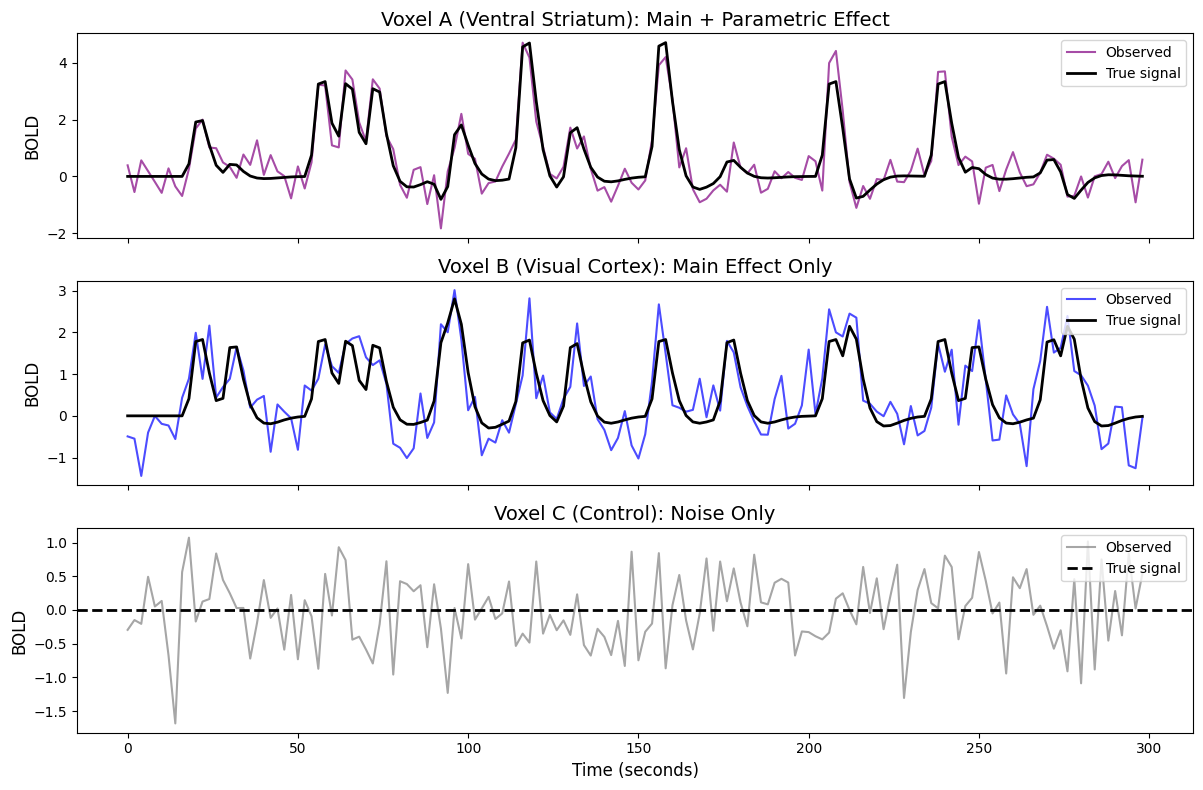

In [ ]:
# @title

# =============================================================================
# STEP 4: Simulate Brain Signals from Different Voxels
# =============================================================================
print("\n" + "=" * 70)
print("STEP 4: Simulating Different Types of Brain Responses")
print("=" * 70)
print("""
Let's simulate 3 types of voxels:

VOXEL A (Ventral Striatum):
- Strong MAIN effect (responds to all rewards)
- Strong PARAMETRIC effect (scales with reward magnitude)

VOXEL B (Visual Cortex):
- Strong MAIN effect (sees the stimulus)
- NO parametric effect (doesn't care about value)

VOXEL C (Control Region):
- Only noise (not task-related)
""")

noise_level = 0.5

# Voxel A: Main + Parametric effect (e.g., reward region)
beta_main_A = 2.0
beta_param_A = 1.5
signal_A = beta_main_A * main_regressor + beta_param_A * param_regressor
noise_A = np.random.randn(n_volumes) * noise_level
voxel_A = signal_A + noise_A

# Voxel B: Main effect only (e.g., visual cortex)
beta_main_B = 2.0
beta_param_B = 0.0
signal_B = beta_main_B * main_regressor + beta_param_B * param_regressor
noise_B = np.random.randn(n_volumes) * noise_level
voxel_B = signal_B + noise_B

# Voxel C: Noise only (control region)
voxel_C = np.random.randn(n_volumes) * noise_level

# Visualize
fig, axes = plt.subplots(3, 1, figsize=(12, 8), sharex=True)

axes[0].plot(time_fmri, voxel_A, 'purple', alpha=0.7, label='Observed')
axes[0].plot(time_fmri, signal_A, 'k-', linewidth=2, label='True signal')
axes[0].set_ylabel('BOLD', fontsize=12)
axes[0].set_title('Voxel A (Ventral Striatum): Main + Parametric Effect', fontsize=14)
axes[0].legend(loc='upper right')

axes[1].plot(time_fmri, voxel_B, 'blue', alpha=0.7, label='Observed')
axes[1].plot(time_fmri, signal_B, 'k-', linewidth=2, label='True signal')
axes[1].set_ylabel('BOLD', fontsize=12)
axes[1].set_title('Voxel B (Visual Cortex): Main Effect Only', fontsize=14)
axes[1].legend(loc='upper right')

axes[2].plot(time_fmri, voxel_C, 'gray', alpha=0.7, label='Observed')
axes[2].axhline(y=0, color='k', linestyle='--', linewidth=2, label='True signal')
axes[2].set_ylabel('BOLD', fontsize=12)
axes[2].set_xlabel('Time (seconds)', fontsize=12)
axes[2].set_title('Voxel C (Control): Noise Only', fontsize=14)
axes[2].legend(loc='upper right')

plt.tight_layout()
plt.savefig('step4_voxel_signals.png', dpi=150)
plt.show()



STEP 5: GLM Estimation and Statistical Inference

Now we fit the GLM: Y = X @ β + ε

Using Ordinary Least Squares (OLS):
β = (X'X)⁻¹ X'Y

The β coefficients tell us:
- β_main: Average response to ANY reward
- β_param: ADDITIONAL response per unit increase in reward


VOXEL A (Striatum)
  β_main      =   1.924  (t =  19.50)
  β_parametric =   1.517  (t =  23.85)
  R² = 0.859

VOXEL B (Visual)
  β_main      =   2.036  (t =  17.60)
  β_parametric =  -0.009  (t =  -0.13)
  R² = 0.679

VOXEL C (Control)
  β_main      =  -0.039  (t =  -0.36)
  β_parametric =   0.031  (t =   0.43)
  R² = 0.002


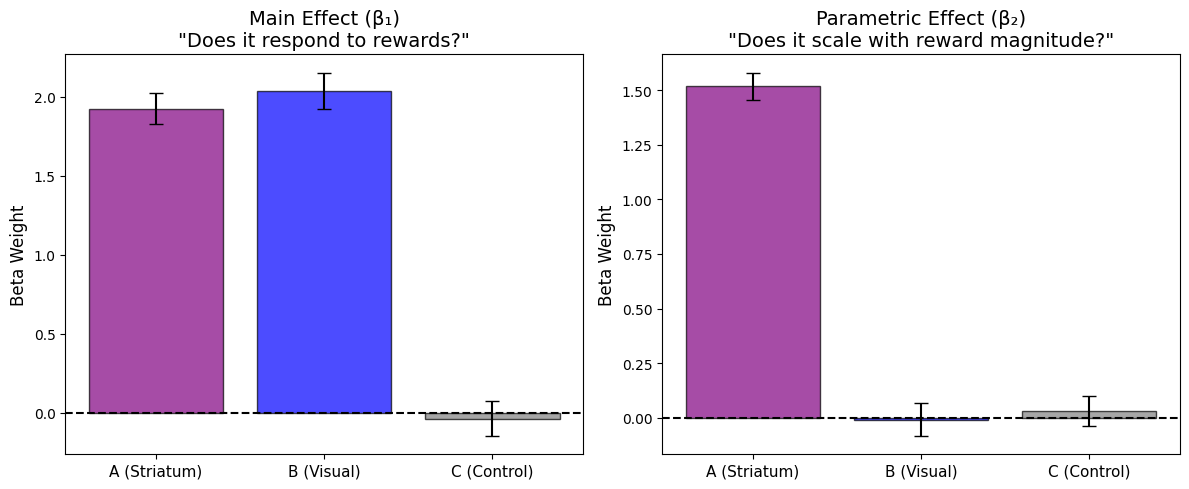

In [ ]:
# @title

# =============================================================================
# STEP 5: Fit the GLM and Interpret Results
# =============================================================================
print("\n" + "=" * 70)
print("STEP 5: GLM Estimation and Statistical Inference")
print("=" * 70)
print("""
Now we fit the GLM: Y = X @ β + ε

Using Ordinary Least Squares (OLS):
β = (X'X)⁻¹ X'Y

The β coefficients tell us:
- β_main: Average response to ANY reward
- β_param: ADDITIONAL response per unit increase in reward
""")

def fit_glm(Y, X):
    """
    Fit GLM using OLS and compute statistics.
    """
    # OLS estimation: β = (X'X)^-1 X'Y
    beta = np.linalg.lstsq(X, Y, rcond=None)[0]

    # Residuals and variance
    Y_pred = X @ beta
    residuals = Y - Y_pred
    df = len(Y) - X.shape[1]  # degrees of freedom
    mse = np.sum(residuals**2) / df

    # Standard errors
    var_beta = mse * np.linalg.inv(X.T @ X)
    se_beta = np.sqrt(np.diag(var_beta))

    # T-statistics
    t_stats = beta / se_beta

    # R-squared
    ss_res = np.sum(residuals**2)
    ss_tot = np.sum((Y - np.mean(Y))**2)
    r_squared = 1 - (ss_res / ss_tot)

    return beta, se_beta, t_stats, r_squared, Y_pred

# Build design matrix
X = np.column_stack([
    main_regressor,      # Main effect
    param_regressor,     # Parametric modulator
    np.ones(n_volumes)   # Intercept
])

# Fit each voxel
results = {}
for name, data in [('A (Striatum)', voxel_A),
                   ('B (Visual)', voxel_B),
                   ('C (Control)', voxel_C)]:
    beta, se, t, r2, pred = fit_glm(data, X)
    results[name] = {'beta': beta, 'se': se, 't': t, 'r2': r2, 'pred': pred}

    print(f"\n{'='*50}")
    print(f"VOXEL {name}")
    print(f"{'='*50}")
    print(f"  β_main      = {beta[0]:7.3f}  (t = {t[0]:6.2f})")
    print(f"  β_parametric = {beta[1]:7.3f}  (t = {t[1]:6.2f})")
    print(f"  R² = {r2:.3f}")

# Visualize beta estimates
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

voxel_names = list(results.keys())
betas_main = [results[v]['beta'][0] for v in voxel_names]
betas_param = [results[v]['beta'][1] for v in voxel_names]
ses_main = [results[v]['se'][0] for v in voxel_names]
ses_param = [results[v]['se'][1] for v in voxel_names]

x_pos = np.arange(len(voxel_names))

# Main effect betas
axes[0].bar(x_pos, betas_main, yerr=ses_main, capsize=5,
            color=['purple', 'blue', 'gray'], alpha=0.7, edgecolor='black')
axes[0].axhline(y=0, color='k', linestyle='--')
axes[0].set_xticks(x_pos)
axes[0].set_xticklabels(voxel_names, fontsize=11)
axes[0].set_ylabel('Beta Weight', fontsize=12)
axes[0].set_title('Main Effect (β₁)\n"Does it respond to rewards?"', fontsize=14)

# Parametric effect betas
axes[1].bar(x_pos, betas_param, yerr=ses_param, capsize=5,
            color=['purple', 'blue', 'gray'], alpha=0.7, edgecolor='black')
axes[1].axhline(y=0, color='k', linestyle='--')
axes[1].set_xticks(x_pos)
axes[1].set_xticklabels(voxel_names, fontsize=11)
axes[1].set_ylabel('Beta Weight', fontsize=12)
axes[1].set_title('Parametric Effect (β₂)\n"Does it scale with reward magnitude?"', fontsize=14)

plt.tight_layout()
plt.savefig('step5_beta_estimates.png', dpi=150)
plt.show()


# 记忆研究中的**后续记忆效应**
这个实验分为两个阶段。

<br>
<br>

---


*第一阶段*：编码阶段（在扫描仪里）

被试会看到一系列的单词，一个一个出现。比如"苹果"、"正义"、"河流"等等。每个单词出现的时候，被试要做一个简单的判断，比如"这个词是抽象的还是具体的？"
注意，我们不会告诉被试要记住这些词。这叫做内隐编码，或者说附带编码。他们只是在做判断任务，记忆是"顺便"发生的。
在这个阶段，我们采集fMRI数据。


<br>
<br>

---


*第二阶段*：测试阶段（可以在扫描仪外）

过一段时间之后，我们给被试做一个记忆测试。我们把学过的旧词和没学过的新词混在一起，让被试判断每个词是"见过"还是"没见过"。

对于每个判断，被试还要给出**信心等级**：

1分 = 猜的
2分 = 有点确定
3分 = 比较确定
4分 = 非常确定


STEP 8: Memory Example — Confidence Ratings

SCENARIO: Participants study words during fMRI scanning.
Later, they take a memory test and rate confidence (1-4):
  1 = Guess, 2 = Somewhat sure, 3 = Pretty sure, 4 = Very sure

QUESTION: Which brain regions show activity that SCALES with 
subsequent memory confidence? (Predicting future memory strength!)

This is the classic "subsequent memory" paradigm with parametric modulation.

Confidence distribution: {np.int64(1): np.int64(3), np.int64(2): np.int64(5), np.int64(3): np.int64(16), np.int64(4): np.int64(6)}
Mean confidence: 2.83

GLM Results:
----------------------------------------
Hippocampus:
  β_encoding = 1.89 (t=24.8)  — responds during encoding
  β_confidence = 1.19 (t=15.5)  — scales with memory strength
Motor Cortex:
  β_encoding = 1.68 (t=24.3)  — responds during encoding
  β_confidence = 0.06 (t=0.8)  — scales with memory strength


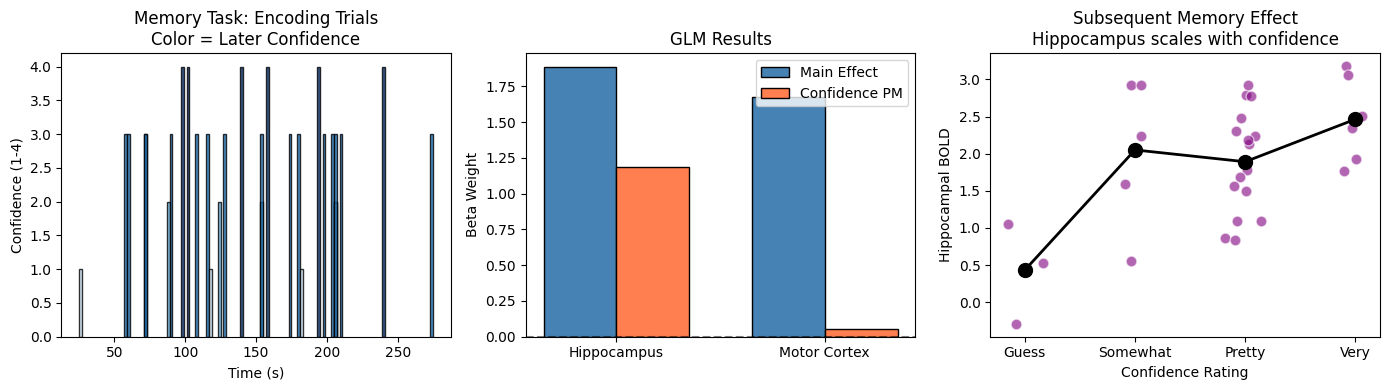


KEY INTERPRETATION:
━━━━━━━━━━━━━━━━━━━
• Hippocampus shows BOTH main effect (responds during encoding) AND 
  parametric effect (more activity → stronger memory later)
  
• Motor cortex shows only main effect (button press) with NO relationship
  to subsequent memory confidence

• This is how we identify regions that PREDICT memory strength!

Common findings with this approach:
  → Hippocampus, parahippocampal cortex, prefrontal cortex
  → Often called "Dm effect" (Difference due to Memory)



In [ ]:
# =============================================================================
# STEP 8: Another Example — Memory Encoding with Confidence Ratings
# =============================================================================
print("\n" + "=" * 70)
print("STEP 8: Memory Example — Confidence Ratings")
print("=" * 70)
print("""
SCENARIO: Participants study words during fMRI scanning.
Later, they take a memory test and rate confidence (1-4):
  1 = Guess, 2 = Somewhat sure, 3 = Pretty sure, 4 = Very sure

QUESTION: Which brain regions show activity that SCALES with
subsequent memory confidence? (Predicting future memory strength!)

This is the classic "subsequent memory" paradigm with parametric modulation.
""")

# --- Simulate Memory Experiment ---
np.random.seed(123)

n_trials_mem = 30
trial_onsets_mem = np.sort(np.random.uniform(10, total_time - 20, n_trials_mem))
trial_onsets_mem = np.round(trial_onsets_mem / TR) * TR

# Confidence ratings (collected AFTER scanning, but modeled at encoding)
confidence = np.random.choice([1, 2, 3, 4], size=n_trials_mem, p=[0.15, 0.25, 0.35, 0.25])
confidence_centered = confidence - np.mean(confidence)

print(f"Confidence distribution: {dict(zip(*np.unique(confidence, return_counts=True)))}")
print(f"Mean confidence: {np.mean(confidence):.2f}")

# --- Build Regressors ---
main_mem, _, _ = create_regressor(trial_onsets_mem, np.ones(n_trials_mem),
                                   time_highres, time_fmri, hrf_highres)
param_mem, _, _ = create_regressor(trial_onsets_mem, confidence_centered,
                                    time_highres, time_fmri, hrf_highres)

# --- Simulate Two Voxels ---
# Hippocampus: Strong subsequent memory effect (scales with confidence)
signal_hipp = 1.8 * main_mem + 1.2 * param_mem
voxel_hipp = signal_hipp + np.random.randn(n_volumes) * 0.5

# Motor cortex: Responds to button press, no memory effect
signal_motor = 1.5 * main_mem + 0.0 * param_mem
voxel_motor = signal_motor + np.random.randn(n_volumes) * 0.5

# --- Fit GLM ---
X_mem = np.column_stack([main_mem, param_mem, np.ones(n_volumes)])

print("\nGLM Results:")
print("-" * 40)
for name, data in [('Hippocampus', voxel_hipp), ('Motor Cortex', voxel_motor)]:
    beta, se, t, r2, _ = fit_glm(data, X_mem)
    print(f"{name}:")
    print(f"  β_encoding = {beta[0]:.2f} (t={t[0]:.1f})  — responds during encoding")
    print(f"  β_confidence = {beta[1]:.2f} (t={t[1]:.1f})  — scales with memory strength")

# --- Visualization ---
fig, axes = plt.subplots(1, 3, figsize=(14, 4))

# Left: Experimental design
colors_conf = plt.cm.Blues(confidence / 4)
for onset, conf, col in zip(trial_onsets_mem, confidence, colors_conf):
    axes[0].bar(onset, conf, width=2, color=col, edgecolor='black', alpha=0.8)
axes[0].set_xlabel('Time (s)')
axes[0].set_ylabel('Confidence (1-4)')
axes[0].set_title('Memory Task: Encoding Trials\nColor = Later Confidence')

# Middle: Beta estimates
voxels = ['Hippocampus', 'Motor Cortex']
beta_main = [fit_glm(voxel_hipp, X_mem)[0][0], fit_glm(voxel_motor, X_mem)[0][0]]
beta_conf = [fit_glm(voxel_hipp, X_mem)[0][1], fit_glm(voxel_motor, X_mem)[0][1]]

x = np.arange(2)
w = 0.35
axes[1].bar(x - w/2, beta_main, w, label='Main Effect', color='steelblue', edgecolor='black')
axes[1].bar(x + w/2, beta_conf, w, label='Confidence PM', color='coral', edgecolor='black')
axes[1].set_xticks(x)
axes[1].set_xticklabels(voxels)
axes[1].set_ylabel('Beta Weight')
axes[1].set_title('GLM Results')
axes[1].legend()
axes[1].axhline(0, color='k', linestyle='--', alpha=0.5)

# Right: Parametric relationship (Hippocampus only)
resp_hipp = extract_trial_responses(voxel_hipp, trial_onsets_mem, time_fmri)
for conf_level in [1, 2, 3, 4]:
    mask = confidence == conf_level
    axes[2].scatter(np.full(mask.sum(), conf_level) + np.random.randn(mask.sum())*0.08,
                    resp_hipp[mask], s=60, alpha=0.6, c='purple', edgecolor='white')

# Mean per confidence level
means = [np.mean(resp_hipp[confidence == c]) for c in [1, 2, 3, 4]]
axes[2].plot([1, 2, 3, 4], means, 'ko-', markersize=10, linewidth=2, label='Mean')
axes[2].set_xlabel('Confidence Rating')
axes[2].set_ylabel('Hippocampal BOLD')
axes[2].set_title('Subsequent Memory Effect\nHippocampus scales with confidence')
axes[2].set_xticks([1, 2, 3, 4])
axes[2].set_xticklabels(['Guess', 'Somewhat', 'Pretty', 'Very'])

plt.tight_layout()
plt.savefig('step8_memory_confidence.png', dpi=150)
plt.show()

print("""
KEY INTERPRETATION:
━━━━━━━━━━━━━━━━━━━
• Hippocampus shows BOTH main effect (responds during encoding) AND
  parametric effect (more activity → stronger memory later)

• Motor cortex shows only main effect (button press) with NO relationship
  to subsequent memory confidence

• This is how we identify regions that PREDICT memory strength!

Common findings with this approach:
  → Hippocampus, parahippocampal cortex, prefrontal cortex
  → Often called "Dm effect" (Difference due to Memory)
""")
